# Titanic Dataset

![Titanic](Imagen_Titanic.png?raw=true)

En esta demostración veremos cuales fueron los factores que determinaron la supervivencia de los pasajeros del Titanic. En la [web de Kaggle](https://www.kaggle.com/c/titanic) podreis encontrar más información! 

El objetivo de la práctica será responder a la pregunta: **¿Qué factores influyeron en la supervivencia de los pasajeros?**

In [87]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Ocultar Código"></form>''')

## Primeros pasos con el dataset: Tratamiento de Datos
En esta primera sección vamos a cargar el dataset así como vamos a obtener sus principales características y hacer las transformaciones que consideremos necesarias:

In [88]:
import pandas

input_file = 'titanic_data.csv'
separador = ","
dataset = pandas.read_csv(filepath_or_buffer=input_file, sep=separador)

#### Cargar Dataset:

En Azure ML se corresponde con este paso:
![Titanic](Cargar_Dataset.png?raw=true)

In [89]:
import pandas

input_file = 'titanic_data.csv'
separador = ","
dataset = pandas.read_csv(filepath_or_buffer=input_file, sep=separador)

Obtendremos algunas medidas básicas del mismo:

In [90]:
print "El numero de filas y columnas que incluye el dataset es: ",dataset.shape
print "\nLos nombres de las columnas son: \n\n",dataset.columns

El numero de filas y columnas que incluye el dataset es:  (1045, 12)

Los nombres de las columnas son: 

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')


A continuación una descripción de las distintas columnas obtenida de la web de [Kaggle](https://www.kaggle.com/c/titanic/data)

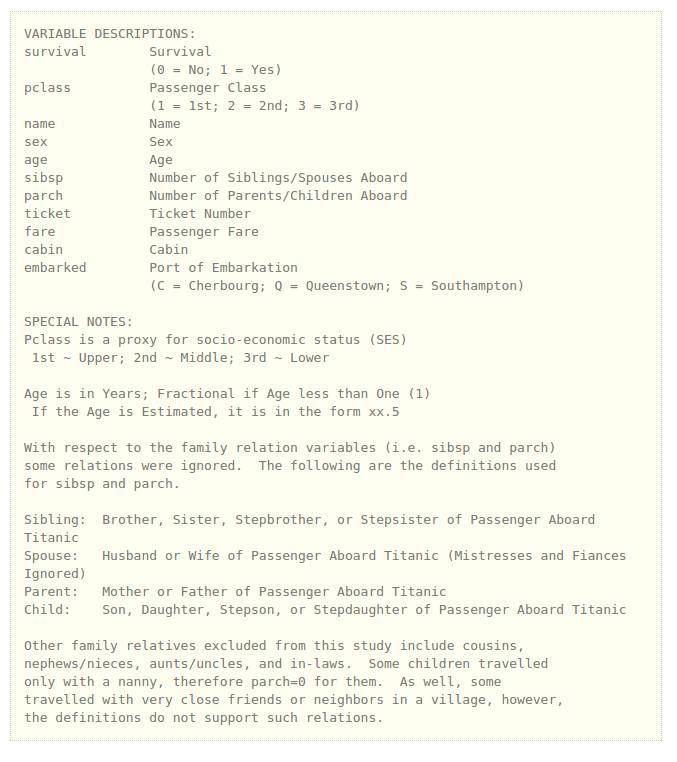

In [91]:
from IPython.display import Image
Image(filename='DescripcionVariablesKaggle.png') 

#### Manipulación del Dataset:

En una primera inspección del dataset vemos que existen huecos en los datos que debemos tratar. Así mismo vamos a renombrar algunas columnas.

Empecemos sustituyendo los valores numéricos por la mediana y los categóricos por la moda:

In [92]:
# Obtener huecos:
print dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1044
Data columns (total 12 columns):
PassengerId    1045 non-null int64
Survived       1045 non-null int64
Pclass         1045 non-null int64
Name           1045 non-null object
Sex            1045 non-null object
Age            1045 non-null float64
SibSp          1045 non-null int64
Parch          1045 non-null int64
Ticket         1045 non-null object
Fare           1045 non-null float64
Cabin          272 non-null object
Embarked       1043 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 106.1+ KB
None


Como podemos ver, existen huecos en la variable Cabina y Embarked. Sustituiremos estos valores con la moda yla mediana respectivamente:

In [93]:
# En Cabin sustituimos por la moda:
dataset['Cabin'] = dataset['Cabin'].fillna(dataset['Cabin'].mode().values[0])

#En Embarkment por la mediana
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode().values[0])

En Azure ML se corresponde con estos pasos:
![Titanic](MissingData_NAN_mediana.png?raw=true)
![Titanic](MissingData_moda.png?raw=true)

Así mismo, por mera comodidad, vamos a cambiar algunos nombres de algunas columnas y algunas variables, como ```Survived``` que en estos momentos es 0 (= no sobrevive) o 1 (= sobrevive) las vamos a pasar a categóricas

In [94]:
# Hacer columna survived categórica:
dataset['Survived'] = dataset['Survived'].apply((lambda x: True if x==1 else False))

# Renombrar columnas:
dataset = dataset.rename(columns={'SibSp':'SiblingSpouse','Parch':'ParientChild','Fare':'FarePrice'})

En Azure ML se corresponde con estos pasos:
![Titanic](Convertir_Variables_Categoricas.png?raw=true)
![Titanic](Columnas_Seleccionadas.png?raw=true)

Con lo cual nuestro dataset tiene este aspecto:

In [95]:
# Distribución de NANs y nombres de columnas:
print dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1044
Data columns (total 12 columns):
PassengerId      1045 non-null int64
Survived         1045 non-null bool
Pclass           1045 non-null int64
Name             1045 non-null object
Sex              1045 non-null object
Age              1045 non-null float64
SiblingSpouse    1045 non-null int64
ParientChild     1045 non-null int64
Ticket           1045 non-null object
FarePrice        1045 non-null float64
Cabin            1045 non-null object
Embarked         1045 non-null object
dtypes: bool(1), float64(2), int64(4), object(5)
memory usage: 99.0+ KB
None


## Modelizacion del dataset: Generación de Modelos
Una vez hemos terminado con el tratamiento del dataset (en este caso es algomuy sencillo), ahora vamos a modelizar el mismo con el objetivo de encontrar los patrones que determinaron la supervivencia de los pasajeros:

El primer paso será generar las variables que sirvan de entrada al modelo: en este caso genereremos nuestros modelos utilizando las variables:
 * **'Sex'**
 * **'Pclas'**
 * **'Age'**
 
y la etiqueta de salida, puesto que queremos determinar la supervivencia (Si/No) de los pasajeros, será: **'Survived'**

Una vez seleccionadas las variables de entrada de nuestro modelo y la salida, tendremos que dividir el dataset en 2 conjutos de datos independientes, el objetivo será entrenar nuestro modelo sobre el dataset de entrenamiento (aquí el modelo debería aprender los patrones que determinan la supervivencia) y un conjunto de test sobre el que se pueda comprobar como de bien generaliza nuestro modelo entrenado sobre un conjunto de datos nuevo.

![Titanic](trainTest.png?raw=true)

En Azure ML se corresponde con estos pasos:
![Titanic](Train&Split.png?raw=true)

Para medir la calidad de nuestro modelo vamos a definir una métrica, en este caso **Accuracy** es una buena opción pues queremos tener una estimación del porcentaje de veces que nuestro modelo fue correcto:

In [101]:
def accuracy_score(truth, pred):
    """ Devuelve accuracy score comparando valores predichos (pred) contra reales (truth). """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return "Predicciones tienen un accuracy de {:.2f}%.".format((truth == pred).mean()*100)
    
    else:
        return "El número de predicciones no es igual al numero de valores reales!"

Lo siguiente que vamos a hacer es eliminar la columa 'Survived' del dataset y marcarla como outcome

In [102]:
# 'Survived' será nuestra etiqueta y el valor que queremos predecir:
outcomes = dataset['Survived']

# Eliminanos las columnas que no formaran parte de la entrada al modelo:
data = dataset.drop(['Survived','Name','Ticket','Cabin','Embarked','PassengerId',\
                     'SiblingSpouse','ParientChild','FarePrice'], axis = 1)

# La columna 'Sex' que toma valores 'female'/'male' la transformamos a 1(mujer) y 0(hombre)
data['Sex'] = data['Sex'].apply(lambda x: 1. if x == 'female' else 0.)

# Representar las primeras 5 filas para comprobar los cambios
print data.head()

   Pclass  Sex  Age
0       3    0   22
1       1    1   38
2       3    1   26
3       1    1   35
4       3    0   35


Vamos a entrenar un [arbol de decision](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) que se entrene con el conjunto de datos de entrenamiento y después se pueda testear sobre el conjunto de datos de test:

In [103]:
# Crear un conjunto de datos que sirvan entrenar el árbol de decision (train) y un conjunto de datos de validacion (test)
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(outcomes, 1, test_size=0.3, random_state=450)
for train_index, test_index in sss:
    X_train = data.iloc[train_index]
    y_train = outcomes.iloc[train_index]
    X_test = data.iloc[test_index]
    y_test = outcomes.iloc[test_index]
    
# Definir el arbol de decision
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_features=3,max_depth=2)

# Entrenarlo con los datos de train
clf = clf.fit(X_train, y_train)

# Crear predicciones
predictions = clf.predict(X_test)

# Obtener resultado:
accuracy_score(y_test, predictions)

'Predicciones tienen un accuracy de 84.08%.'

Ahora vamos a representar el arbol de decision:

Index([u'Pclass', u'Sex', u'Age'], dtype='object')


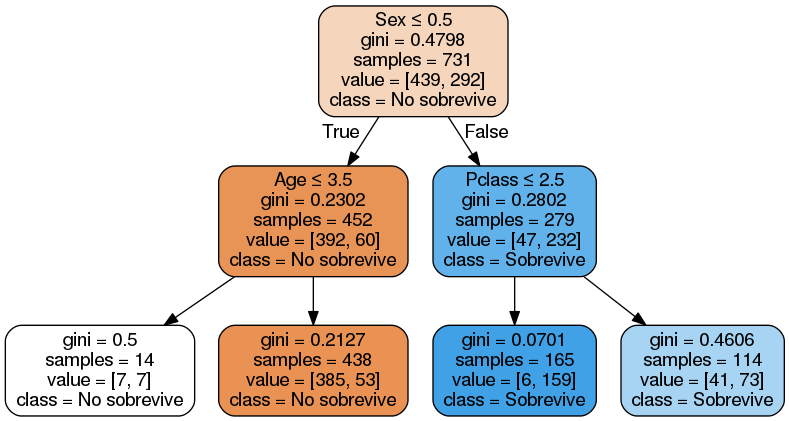

In [104]:
from sklearn.externals.six import StringIO
import pydot 
print data.columns
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=data.columns,
                         class_names=['No sobrevive','Sobrevive'], 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())